In [4]:
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.optimize import curve_fit
import numpy as np
from scipy import stats
import sys
from read_arrays_from_csv import bhl_object_list, bhl_object_labels
from plot_variables import tidy_data_labels, first_index, interpolate_data, moving_average, eddington_rate
from matplotlib.ticker import FixedLocator

In [5]:
##########################################################################################################
#                               Plot Radius Resolution vs Accretion Rate
#
# to run: python -i plot_radius_relationship.py [csv1] [csv2] [csv3] [output_plotname e.g MF-BHL]
# for 2x2 update: list MF runs first, then BHL runs. Name: MF+BHL (in order of low res to high res)
##########################################################################################################

# # Define the line fit function
# def line_fit(x, a, b, c):
#     return a * np.exp(-b * x) + c

# Define the line fit function
def line_fit(x, *p):
    return 10**p[1] * x**p[0]


def A_dyn_friction(M_msun, c_s_kmps):
    # value of r_s (softening length) is uncertain
    # take from table 1: https://academic.oup.com/mnras/article/487/1/1227/5491314?login=false
    r_s_cm = 4.625e19 # in cm at z = 25, ~ 0.38 kpcph
    M_g = M_msun * 1.98847e33
    c_s_cmps = c_s_kmps * 1e4
    G_cgs = 6.6743e-8
    return 2 * M_g * G_cgs / (c_s_cmps**2 * r_s_cm)

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

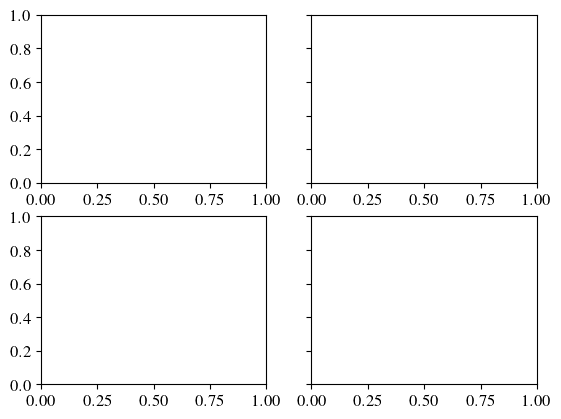

In [6]:
# set x-axis extent in Myr and simulation set
xlim = 0.4 #0.225 for 1S
sim = "s1-10.8msun-"
atol = 5e-4  # 7e-2 for 1B.m, 1e-4 otherwise
eddington = True
accretion = sys.argv[-1] # naming plot with accretion scheme
c = ['blueviolet', 'turquoise', 'limegreen', 'darkgreen']  # line colours s1
#c = ['indigo', 'blueviolet', 'violet', 'dodgerblue', 'turquoise', 'limegreen', 'darkgreen'] # line colours s2S

min_hl = max_hl = min_bondi = max_bondi = 1

# font settings
linewidth = 1.5
fontsize = 12
rc('font', **{'family': 'serif', 'serif': ['Times'], 'weight': 'light'})
rc('text', usetex=True)
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams['font.size'] = fontsize
plt.rcParams['lines.linewidth'] = linewidth

# initialise figure
fig = plt.figure()
num_subplots = 2
fig, axs = plt.subplots(num_subplots, 2, sharex=False, sharey=True)

# tidy data labels
l = tidy_data_labels(bhl_object_labels)

# allocate cell widths to be shown based on input (low res -> high res)
if sim == "s1-270msun-":
    dx = [1.229791e-02, 3.074475e-03, 1.537645e-03, 7.692833e-04]
elif sim == "s1-10.8msun-":
    dx = [2.459867e-02, 1.229940e-02, 3.074829e-03, 7.692833e-04]
elif sim == "s2-270msun-":
    dx = [8.298311e-03, 2.074568e-03, 1.537645e-03, 7.687095e-04, 3.8435475e-04, 1.296596e-04]
elif sim == "s2-10.8msun-":
    #dx = [1.297054e-04, 5.188221e-04, 1.297054e-03, 2.079909e-03, 4.16e-03, 8.32e-03]
    dx = [0.00832, 0.00416, 0.002079909, 0.001297054, 0.0005188221, 0.0001297054]
elif sim == "s2-10.8msun-2-":
    dx = [1.3e-03, 5.2e-04, 1.3e-04]

# define baseline age and accrate lines + number of data points
i_start = 5 # starting index
baseline_age_raw = bhl_object_list[0].ages[i_start:]
n_data_max = baseline_age_raw.shape[0]
N = int(n_data_max/100)
baseline_age = interpolate_data(bhl_object_list[0].ages[i_start:], N=N)
baseline_accrate = interpolate_data(bhl_object_list[0].accrates[i_start:], N=N)
baseline_mass = interpolate_data(bhl_object_list[0].mass[i_start:], N=N)

# parameters
alpha = 0.5
time_cutoff = xlim  # Myrs
window_size = 1
i_mf = np.arange(int(len(bhl_object_list) / 2))
i_bhl = np.arange(int(len(bhl_object_list) / 2), len(bhl_object_list))

# array lists
lst_accrate_bhl = []
lst_res_hl_bhl = []
lst_res_bondi_bhl = []
lst_accrate_mf = []
lst_res_hl_mf = []
lst_res_bondi_mf = []

[]

In [ ]:
for i, BHL in enumerate(bhl_object_list):

    # convert ages from yrs to Myrs
    BHL.ages = np.array(BHL.ages) / 1e6

    # find index of age that matches end age of time limit
    i_age = first_index(BHL.ages[i_start:], time_cutoff, rtol=1e-8, atol=atol) # 7e-2 for 1B.m, 1e-4 otherwise

    # calculate mass and hl_radius moving averages
    accrate = moving_average(BHL.accrates[i_start:i_age], window_size)
    eddrate = eddington_rate(moving_average(BHL.mass[i_start:i_age], window_size))
    if eddington:
        accrate = accrate/eddrate
    hl_radius = moving_average(BHL.hl_radius[i_start:i_age], window_size)
    bondi_radius = moving_average(BHL.bondi_radius[i_start:i_age], window_size)

    # calculate how many cells it's resolving the hl radius by
    if i in i_mf:
        dx_res_hl = hl_radius/dx[i]
        dx_res_bondi = bondi_radius / dx[i]
    else: 
        dx_res_hl = hl_radius / dx[i - int(len(bhl_object_list) / 2)]
        dx_res_bondi = bondi_radius / dx[i - int(len(bhl_object_list) / 2)]

    # interpolate this array over N evenly spaced points
    interp_accrate = interpolate_data(accrate, N=N)
    interp_eddrate = interpolate_data(eddrate, N=N)
    interp_hl = interpolate_data(dx_res_hl, N=N)
    interp_bondi = interpolate_data(dx_res_bondi, N=N)
    accrate = interp_accrate
    eddrate = interp_eddrate
    dx_res_hl = interp_hl
    dx_res_bondi = interp_bondi

    # perform linear regression
    slope_hl, intercept_hl, r_value_hl, p_value_hl, std_err_hl = stats.linregress(np.log10(accrate), np.log10(dx_res_hl))
    slope_bondi, intercept_bondi, r_value_bondi, p_value_bondi, std_err_bondi = stats.linregress(np.log10(accrate), np.log10(dx_res_bondi))
    p_hl = [slope_hl, intercept_hl]
    p_bondi = [slope_bondi, intercept_bondi]
    print("++++++++ HL linear fit stats +++++++++++")
    print("r-squared:", r_value_hl ** 2)
    print("p-value:", p_value_hl)
    print("std_err:", std_err_hl)
    print(f"dx_res_hl = {10**intercept_hl:.2e} * (M. ** {slope_hl:.2e})")

    # make line strings
    line_str_hl = r"$\rm  %.2f\, (\dot{M}/ \dot{M}_{Edd})^{%.3f}$" % (10 ** intercept_hl, slope_hl)
    line_str_bondi = r"$\rm  %.2f\, (\dot{M}/ \dot{M}_{Edd})^{%.3f}$" % (10 ** intercept_bondi, slope_bondi)

    if i in i_mf:

        # add the ages and radii to lst (for Pearson coeff calculation)
        lst_accrate_mf.append(accrate)
        lst_res_hl_mf.append(dx_res_hl)
        lst_res_bondi_mf.append(dx_res_bondi)

        # 1) HL radius resolution in cell widths
        axs[0, 0].scatter(dx_res_hl, accrate, color=c[i], linestyle='solid', label=l[i], alpha=alpha)
        # axs[0, 0].plot(accrate, line_fit(accrate, *p_hl), c[i], linestyle='dashed',
        #             #label=line_str_hl
        #             )

        # 2) Bondi radius resolution in cell widths
        axs[0, 1].scatter(dx_res_bondi, accrate, color=c[i], linestyle='solid', label=l[i], alpha=alpha)
        # axs[1, 0].plot(accrate, line_fit(accrate, *p_bondi), c[i], linestyle='dashed',
        #             #label=line_str_bondi
        #             )

    else:

        # add the ages and radii to lst (for Pearson coeff calculation)
        lst_accrate_bhl.append(accrate)
        lst_res_hl_bhl.append(dx_res_hl)
        lst_res_bondi_bhl.append(dx_res_bondi)

        # 1) HL radius resolution in cell widths
        axs[1, 0].scatter(dx_res_hl, accrate, color=c[i - int(len(bhl_object_list) / 2)],
                            linestyle='solid', label=l[i], alpha=alpha)
        # axs[0, 1].plot(accrate, line_fit(accrate, *p_hl), color=c[i - int(len(bhl_object_list) / 2)],
        #                linestyle='dashed', 
        #                #label=line_str_hl
        #                )

        # 2) Bondi radius resolution in cell widths
        axs[1, 1].scatter(dx_res_bondi, accrate, color=c[i - int(len(bhl_object_list) / 2)],
                            linestyle='solid', label=l[i], alpha=alpha)
        # axs[1, 1].plot(accrate, line_fit(accrate, *p_bondi), color=c[i - int(len(bhl_object_list) / 2)],
        #                linestyle='dashed', 
        #                #label=line_str_bondi
        #                )

    # update y-axis limits
    min_hl = min(dx_res_hl.min(), min_hl)
    max_hl = max(dx_res_hl.max(), max_hl)
    min_bondi = min(dx_res_bondi.min(), min_bondi)
    max_bondi = max(dx_res_bondi.max(), max_bondi)


# concatenate the arrays: creating one dataset of all points on the plot
accrate_total_bhl = np.concatenate(lst_accrate_bhl)
res_hl_total_bhl = np.concatenate(lst_res_hl_bhl)
res_bondi_total_bhl = np.concatenate(lst_res_bondi_bhl)

accrate_total_mf = np.concatenate(lst_accrate_mf)
res_hl_total_mf = np.concatenate(lst_res_hl_mf)
res_bondi_total_mf = np.concatenate(lst_res_bondi_mf)

# calculate Pearson coeff for BHL and MF
pearson_coeff_hl_bhl = np.corrcoef(accrate_total_bhl, res_hl_total_bhl)[0, 1]
pearson_coeff_bondi_bhl = np.corrcoef(accrate_total_bhl, res_bondi_total_bhl)[0, 1]
line_str_pearson_hl_bhl = r"Pearson Coeff = $\rm %.2f$" % (pearson_coeff_hl_bhl)
line_str_pearson_bondi_bhl = r"Pearson Coeff = $\rm %.2f$" % (pearson_coeff_bondi_bhl)

pearson_coeff_hl_mf = np.corrcoef(accrate_total_mf, res_hl_total_mf)[0, 1]
pearson_coeff_bondi_mf = np.corrcoef(accrate_total_mf, res_bondi_total_mf)[0, 1]
line_str_pearson_hl_mf = r"Pearson Coeff = $\rm %.2f$" % (pearson_coeff_hl_mf)
line_str_pearson_bondi_mf = r"Pearson Coeff = $\rm %.2f$" % (pearson_coeff_bondi_mf)

# calculate Kendall tau and p-value
tau, p_value = stats.kendalltau(accrate_total_bhl, res_hl_total_bhl)
print("Kendall's tau:", tau)
print("p-value:", p_value)

# perform linear regression on aggregate data per accretion scheme and radius resolution
slope_hl, intercept_hl, r_value_hl, p_value_hl, std_err_hl = stats.linregress(np.log10(res_hl_total_bhl), np.log10(accrate_total_bhl))
slope_bondi, intercept_bondi, r_value_bondi, p_value_bondi, std_err_bondi = stats.linregress(np.log10(res_bondi_total_bhl), np.log10(accrate_total_bhl))
line_str_pearson_hl_bhl = r"R-squared = $\rm %.2f$" % (r_value_hl ** 2)
line_str_pearson_bondi_bhl = r"R-squared = $\rm %.2f$" % (r_value_bondi ** 2)
p_hl_bhl = [slope_hl, intercept_hl]
p_bondi_bhl = [slope_bondi, intercept_bondi]

slope_hl, intercept_hl, r_value_hl, p_value_hl, std_err_hl = stats.linregress(np.log10(res_hl_total_mf), np.log10(accrate_total_mf))
slope_bondi, intercept_bondi, r_value_bondi, p_value_bondi, std_err_bondi = stats.linregress(np.log10(res_bondi_total_mf), np.log10(accrate_total_mf))
line_str_pearson_hl_mf = r"R-squared = $\rm %.2f$" % (r_value_hl ** 2)
line_str_pearson_bondi_mf = r"R-squared = $\rm %.2f$" % (r_value_bondi ** 2)
p_hl_mf = [slope_hl, intercept_hl]
p_bondi_mf = [slope_bondi, intercept_bondi]

################################ Format Plot ####################################

# label axes
yticks = np.logspace(-3, 3, 7)
for i in range(num_subplots):
    for j in range(num_subplots):

        axs[1, 0].set_xlabel(r"$R_{\rm Bondi}$ Resolution (cell widths)", fontdict=None)
        axs[1, 1].set_xlabel(r"$R_{\rm HL}$ Resolution (cell widths)", fontdict=None)

        # x-axis ticks
        axs[i, j].set_yticks(yticks)
        # Define minor y-ticks for log scale
        yticks_minor = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 2, 3, 4, 5, 6, 7, 8, 9, 20, 30, 40, 
                        50, 60, 70, 80, 90, 200, 300, 400, 500, 600, 700, 800, 900]

        axs[i, j].minorticks_on()
        axs[i, j].yaxis.set_minor_locator(FixedLocator(yticks_minor))
        #axs[i, j].xaxis.set_minor_locator(plt.MultipleLocator(0.02))
        axs[i, j].tick_params(axis="x", which='minor', length=2, direction="in")
        axs[i, j].tick_params(axis="x", which='major', labelsize=fontsize, width=1.5, length=3, direction="in")
        axs[i, j].tick_params(axis="y", which='minor', length=2, direction="in")
        axs[i, j].tick_params(axis="y", which='major', labelsize=fontsize, width=1.5, length=3, direction="in")
        axs[i, j].set_yscale('log')
        axs[i, j].set_xscale('log')

        #axs[i, j].legend(fontsize=fontsize-4, ncol=2)

        # set no cells = 1 line
        axs[i, j].axhline(y=1, color="grey", linestyle='dashdot', lw=linewidth, alpha=alpha)

        # set ylim
        axs[i, j].set_ylim(8e-5, 3e3)

# # format individual subplots
# axs[0, 0].set_ylabel(r"$R_{\rm HL}$ Resolution (cell widths)", fontdict=None)
# axs[0, 0].set_xscale('log')
# axs[0, 0].set_title(str(sim) + str(accretion) + "-" + str(xlim) + "Myr", fontdict=None)
# axs[0, 0].set_ylim(min_hl - min_hl*0.1, max_hl + max_hl*0.2)
# axs[1, 0].set_ylabel(r"$R_{\rm Bondi}$ Resolution (cell widths)", fontdict=None)
# axs[1, 0].set_ylim(min_bondi - min_bondi*0.1, max_bondi + max_bondi*0.25)
# axs[1, 0].legend(fontsize=8.5, ncol=3)
# axs[0, 0].legend(fontsize=8.5, ncol=3)

# format individual subplots
if str(accretion)[:2] == "MF":
    accretion_type = "Mass-Flux"
else:
    accretion_type = "BHL"
#axs[0, 0].set_title(str(sim) + str(accretion)[:2] + "-" + str(xlim) + "Myr", fontdict=None)
linear_fit_color = "yellow"
#axs[0, 0].set_title(str(accretion_type), fontdict=None)
#axs[0, 0].legend(fontsize=fontsize - 4, ncol=2, loc="upper left")
axs[0, 0].text(0.63, 0.065, line_str_pearson_bondi_mf, fontsize=fontsize-4, bbox=dict(facecolor='white', edgecolor='lightgrey'), transform=axs[0, 0].transAxes)
axs[0, 1].plot(accrate_total_mf, line_fit(accrate_total_mf, *p_hl_mf), linear_fit_color, linestyle='solid')
axs[0, 0].set_xticklabels([])

# ylabels
if eddington:
    axs[1, 0].set_ylabel(r"$\rm \dot{M} / \dot{M}_{Edd}$")
    axs[0, 0].set_ylabel(r"$\rm \dot{M} / \dot{M}_{Edd}$")
else:
    axs[1, 0].set_ylabel(r"$\rm \dot{M} (M_\odot/yr) $")
    axs[0, 0].set_ylabel(r"$\rm \dot{M} (M_\odot/yr) $")
yticklabels = [r"$\rm 10^{-3}$", r"$\rm 10^{-2}$", r"$\rm 10^{-1}$", r"$\rm 10^{0}$", r"$\rm 10^{1}$", r"$\rm 10^{2}$", r"$\rm 10^{3}$"]
axs[0, 0].set_yticks(yticks)
axs[1, 0].set_yticks(yticks)
axs[0, 0].set_yticklabels(yticklabels)
axs[1, 0].set_yticklabels(yticklabels)

axs[1, 0].text(0.63, 0.065, line_str_pearson_bondi_mf, fontsize=fontsize-4, bbox=dict(facecolor='white', edgecolor='lightgrey'), transform=axs[1, 0].transAxes)
# plot linear fit
axs[1, 1].plot(accrate_total_bhl, line_fit(accrate_total_bhl, *p_hl_bhl), linear_fit_color, linestyle='solid')


axs[0, 1].legend(fontsize=fontsize - 4, ncol=2, loc="upper left")
axs[0, 1].text(0.66, 0.065, line_str_pearson_hl_bhl, fontsize=fontsize-4, bbox=dict(facecolor='white', edgecolor='lightgrey'), transform=axs[0, 1].transAxes)
axs[0, 1].text(1.02, 0.5, 'Mass-Flux', transform=axs[0, 1].transAxes, ha='left', va='center')
#axs[0, 1].set_title(str(sim) + str(accretion)[3:6] + "-" + str(xlim) + "Myr", fontdict=None)
#axs[0, 1].set_title("BHL", fontdict=None)
axs[0, 1].tick_params(axis="y", which='minor', length=2, direction="in")
axs[0, 1].tick_params(axis="y", which='major', width=1, length=4, direction="in")
axs[0, 1].set_yticklabels([])
axs[0, 1].set_xticklabels([])
axs[0, 0].plot(accrate_total_mf, line_fit(accrate_total_mf, *p_bondi_mf), linear_fit_color, linestyle='solid')

axs[1, 1].tick_params(axis="y", which='minor', length=2, direction="in")
axs[1, 1].tick_params(axis="y", which='major', width=1, length=4, direction="in")
axs[1, 1].set_yticklabels([])
axs[1, 1].text(0.66, 0.065, line_str_pearson_bondi_bhl, fontsize=fontsize-4, bbox=dict(facecolor='white', edgecolor='lightgrey'), transform=axs[1, 1].transAxes)
axs[1, 0].plot(accrate_total_bhl, line_fit(accrate_total_bhl, *p_bondi_bhl), linear_fit_color, linestyle='solid')
axs[1, 1].text(1.02, 0.5, 'BHL', transform=axs[1, 1].transAxes, ha='left', va='center')
axs[1, 1].legend(fontsize=fontsize - 4, ncol=2, loc="upper left")

# set xlims
axs[0, 0].set_xlim(min_hl - min_hl * 0.1, max_hl + max_hl * 0.2)
axs[1, 0].set_xlim(min_hl - min_hl * 0.1, max_hl + max_hl * 0.2)
axs[0, 1].set_xlim(min_bondi - min_bondi * 0.1, max_bondi + max_bondi * 0.25)
axs[1, 1].set_xlim(min_bondi - min_bondi * 0.1, max_bondi + max_bondi * 0.25)

# save plot as pdf
fig = plt.gcf()
fig.subplots_adjust(wspace=0.02, hspace=0.02)
fig.set_size_inches(8, 6)
plot_name = 'plots/accrate-dx_res-' + str(sim) + str(accretion) + "-" + str(xlim) + 'Myr.pdf'
fig.savefig(plot_name, bbox_inches='tight')
print("created ",plot_name) # notification of completion